## Advanced NLP - Final Project: Predicting Amazon Review Categories
Group: Erika Gutierrez, Lucas Santos, Margherita Phillip and Renato Vassalo

## Guidelines

Here are the guidelines. The objective is to go from a baseline model to a better one with DL. I would like you to follow in the final report:
* Explain briefly the classification you tackle, the random classifier performance and the state-of-the-art for this task
* The choice of the metrics to evaluate the models
* A clear datasets split and descriptive statistics of the sets. Train / development and test sets
* Implementation of a baseline (ie non ML solution) + metrics on test set
* Implementation of a RNN solution + metrics on test set
* Implementation of a BERT model + metrics on test set
* A few examples with their predicted outputs for each of the three implementations
* Error Analysis of the models: where did it learn well / bad ?
* Comment the metrics: can you explain the metrics difference between implementations? Where do you stand regarding SOA/random classifier?
* Biases: Try to identify any type of bias in the models
Improve your BERT solution depending on error analysis, biases or other analysis you think is relevant
* Next steps: What are the main limitations of your models? What would be the next steps to improve it?
You should comment any decision you take regarding your development. 


To evaluate the final report I will take into consideration:
* Quality and clarity of report, notebook and code
* The difficulty of the task (depends on the dataset mainly, the easier the task the higher should be the results)
* Relevance of observations related to evaluations, error analysis, biases and next steps
* Quality of the defense (April 3rd or 4th)

## Import libraries and data
We load the libraries in two parts because we discovered issues with the encoding. 

In [1]:
# install deps
!pip install datasets transformers sentence_transformers umap-learn

# dataset
#from datasets import load_dataset
import pandas as pd
import csv
import seaborn as sns

# model
from transformers import AutoTokenizer, TFAutoModel, pipeline
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score
from sentence_transformers import SentenceTransformer
import spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
import locale

def getpreferrencoding(do_setlocale = True):
  return lambda: "UTF-8"

locale.getpreferredencoding = locale.getpreferredencoding
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
!python -m spacy download en_core_web_md

# utils
from sklearn.utils import shuffle
import numpy as np
import string
from collections import Counter
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_similarity
import umap.umap_ as umap
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

#visualize
import matplotlib.pyplot as plt
%matplotlib inline

2023-03-31 20:31:28.174935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 6.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [4]:
# Importing the data
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

#path = "/content/drive/MyDrive/AdvancedNLP_finalproject/Files/"
path = "/content/drive/Shared drives/AdvancedNLP/NLP_files/"

Mounted at /content/drive


In [5]:
# Takes 2-3 minutes to load 
df_og = pd.read_csv(path + 'amazon_reviews_multilingual_US_v1_00.tsv', sep='\t', header=0, on_bad_lines='skip')


## Data set and task overview: predicting amazon review category

We work with the amazon review data set: https://huggingface.co/datasets/amazon_us_reviews

Our aim is to predict, which category the review belongs to. As there are tens of categories, this would be a difficult and computationally very intensive task. Therefore we work with only a subset of five categories. We drop the rest of the data and deliberately choose categories that have a comparable number of entries - omitting categories such as `Mobile Apps` or `Music` for which there are an order of magnitude more data points.

We also select a couple of categories that may be slightly harder to predict due to similarities in the reviews - namely kitchen and home.





**update according to final choice**

These are the categories we work with. The full list of available categories is listed below.
1. shoes_dataset = load_dataset('amazon_us_reviews', 'Shoes_v1_00')
2. toys_dataset = load_dataset('amazon_us_reviews', Toys_v1_00')
3. kitchen_dataset = load_dataset('amazon_us_reviews', 'Kitchen_v1_00')
4. Furniture_dataset = load_dataset('amazon_us_reviews', 'Furniture_v1_00')
5. digital_ebook_dataset = load_dataset('amazon_us_reviews', 'Digital_Ebook_Purchase_v1_01')

Available categories: 
- 'Wireless_v1_00',
- 'Watches_v1_00',
- 'Video_Games_v1_00',
- 'Video_DVD_v1_00',
- 'Video_v1_00', 
- 'Toys_v1_00',
- 'Tools_v1_00',
- 'Sports_v1_00',
- 'Software_v1_00',
- 'Shoes_v1_00',
- 'Pet_Products_v1_00',
- 'Personal_Care_Appliances_v1_00', 
- 'PC_v1_00',
- 'Outdoors_v1_00',
- 'Office_Products_v1_00',
- 'Musical_Instruments_v1_00',
- 'Music_v1_00',
- 'Mobile_Electronics_v1_00', 
- 'Mobile_Apps_v1_00',
- 'Major_Appliances_v1_00',
- 'Luggage_v1_00',
- 'Lawn_and_Garden_v1_00',
- 'Kitchen_v1_00',
- 'Jewelry_v1_00',
- 'Home_Improvement_v1_00',
- 'Home_Entertainment_v1_00',
- 'Home_v1_00',
- 'Health_Personal_Care_v1_00',
- 'Grocery_v1_00', 'Gift_Card_v1_00', 
- 'Furniture_v1_00',
- 'Electronics_v1_00',
- 'Digital_Video_Games_v1_00',
- 'Digital_Video_Download_v1_00',
- 'Digital_Software_v1_00',
- 'Digital_Music_Purchase_v1_00', 
- 'Digital_Ebook_Purchase_v1_00',
- 'Camera_v1_00',
- 'Books_v1_00',
- 'Beauty_v1_00',
- 'Baby_v1_00',
- 'Automotive_v1_00',
- 'Apparel_v1_00',
- 'Digital_Ebook_Purchase_v1_01', 
- 'Books_v1_01',
- 'Books_v1_02']


In [ ]:
#datasets = [(shoes_dataset, "shoes")]

#for dataset, name in datasets:
#    for split in ["train"]:
#        dataset[split].to_csv(f"{name}_{split}.csv")


## Reset data
Useful to reset df to refer to the original data set rather than having to load it from scratch.

In [6]:
df = df_og.copy()

## Exploring the data set
We look at the relative number of data points in each category, select the subset we choose to work with and remove a small number of rows with missing values. We also generate a wordcloud for each category (after tokenizing the text).

In [ ]:
print(df.shape)
df.head()

(6900886, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,53096384,R63J84G1LOX6R,1563890119,763187671,The Sandman Vol. 1: Preludes and Nocturnes,Books,4.0,0.0,1.0,N,N,ignore the review below,this is the first 8 issues of the series. it i...,1995-08-13
1,US,53096399,R1BALOA11Z06MT,1559947608,381720534,The 22 Immutable Laws of Marketing,Books,4.0,0.0,0.0,N,N,awesome,I've always been partial to immutable laws. Th...,1995-08-17
2,US,53096332,R1LLAY5W5PZUS4,0671701800,860650224,Contact,Books,5.0,1.0,2.0,N,N,Read the book. It's good.,This is a book about first contact with aliens...,1995-08-30
3,US,53096335,R3R9VTJ82FXECQ,0425132153,624269601,Good Omens,Books,5.0,0.0,0.0,N,N,Funniest book ever written about the Anti-Christ,This is quite possibly *the* funniest book I h...,1995-09-11
4,US,51747709,R1P5J3FNBWTFXY,0517122707,161411385,A Confederacy of Dunces,Books,5.0,0.0,0.0,N,N,A winner that didn't last. Only a mothers love...,The story behind the book is almost better tha...,1995-10-17


### Categories and missing values

**Overivew of categories**

In [ ]:
df['product_category'].unique()

array(['Books', 'Music', 'Video', 'Video DVD', 'Toys', 'Tools',
       'Office Products', 'Video Games', 'Software',
       'Digital_Music_Purchase', 'Home Entertainment', 'Electronics',
       'Digital_Ebook_Purchase', 'Digital_Video_Download', 'Kitchen',
       'Camera', 'Outdoors', 'Musical Instruments', 'Sports', 'Watches',
       'PC', 'Home', 'Wireless', 'Beauty', 'Baby', 'Home Improvement',
       'Apparel', 'Shoes', 'Lawn and Garden', 'Mobile_Electronics',
       'Health & Personal Care', 'Grocery', 'Luggage',
       'Personal_Care_Appliances', 'Automotive', 'Mobile_Apps',
       'Furniture', '2012-12-22', 'Pet Products'], dtype=object)

<Axes: >

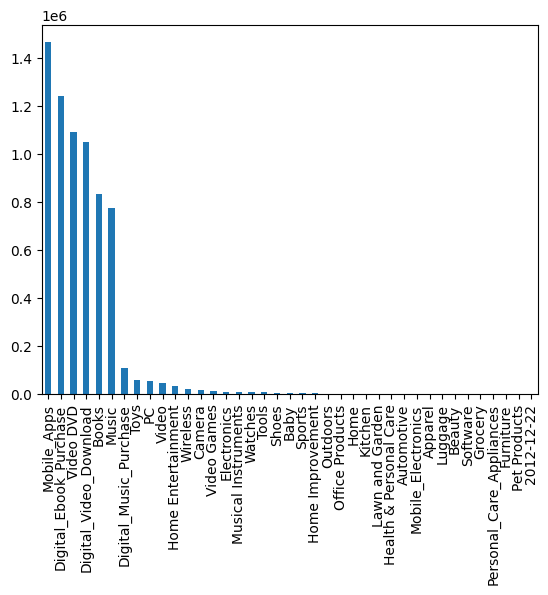

In [ ]:
df['product_category'].value_counts().plot(kind='bar')

In [ ]:
# reset the data if desired (rather than importing from scratch)
df = df.copy()

**Selecting categories**

As discussed above, the original dataset is too big. Thus we select some categories to proceed with our task of category prediction.

(Still a big dataset with more than 1M rows...)

In [ ]:
# all five categories
categories = ['Shoes', 'Home', 'Kitchen','Toys', 'Electronics'] 

# three categories
#categories = ['Shoes', 'Home', 'Kitchen'] #We can change the categories - 'Toys', 'Electronics',
df_1 = df[df['product_category'].isin(categories)]

In [ ]:
print(df_1['product_category'].value_counts())

Toys           57465
Electronics    11421
Shoes           7342
Home            1998
Kitchen         1834
Name: product_category, dtype: int64


In [ ]:
print(df_1.shape)
print(df_1.columns)

(80060, 15)
Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date'],
      dtype='object')


**Missing values**

We only have a small number of 9 NAs in the whole dataset, so we decide to drop those observations.

In [ ]:
print(df_1.isna().sum())

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      1
review_body          5
review_date          3
dtype: int64


In [ ]:
df_1 = df_1.dropna()
print(df_1.isna().sum().sum())
df_1.shape

0


(80051, 15)

**Review category prevalence**

The shoe category is by far the largest, so we would ideally like to consider an alternative.

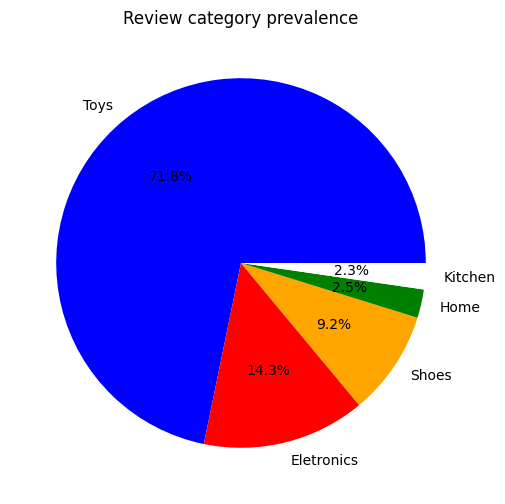

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
y = df_1['product_category'].value_counts().values / len(df_1) * 100
ax.pie(y, colors=['blue', 'red', 'orange', 'green', 'white'], autopct='%1.1f%%', labels=['Toys', 'Eletronics', 'Shoes', 'Home', 'Kitchen']) #
# for three values
#ax.pie(y, colors=['blue', 'red', 'orange'], autopct='%1.1f%%', labels=['Shoes',  'Home', 'Kitchen']) #'Toys', 'Electronics', 'green', 'white'
ax.set_title('Review category prevalence')
fig.show()

### Tokenization and word clouds
We first define a spacy tokenizer and go on to generate separate word clouds for each category.

In [ ]:
nlp = spacy.load("en_core_web_sm", exclude=["ner"])

# extracting all the adjectives and averbs of each text
def spacy_tokenizer(texts, nlp=nlp):
  docs = nlp.pipe(texts)
  tokens = []
  for doc in tqdm(docs, total=len(texts)):
    _tokens = [tok.text.lower() for tok in doc 
               if tok.pos_ in ['ADJ', 'ADV']]
    tokens.append(_tokens)
  return tokens

In [ ]:
df_1['review_body'] = df_1['review_body'].astype(str)

# takes around 5 min to run
tokens_shoes = spacy_tokenizer(df_1.loc[df_1.loc[:, 'product_category'] == 'Shoes', 'review_body'].values)
tokens_toys = spacy_tokenizer(df_1.loc[df_1.loc[:, 'product_category'] == 'Toys', 'review_body'].values)
tokens_electronics = spacy_tokenizer(df_1.loc[df_1.loc[:, 'product_category'] == 'Electronics', 'review_body'].values)
tokens_home = spacy_tokenizer(df_1.loc[df_1.loc[:, 'product_category'] == 'Home', 'review_body'].values)
tokens_kitchen = spacy_tokenizer(df_1.loc[df_1.loc[:, 'product_category'] == 'Kitchen', 'review_body'].values)

100%|██████████| 1834/1834 [00:08<00:00, 209.80it/s]


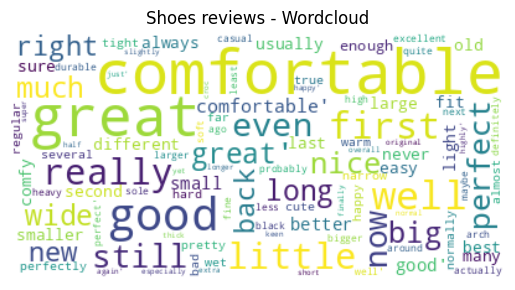

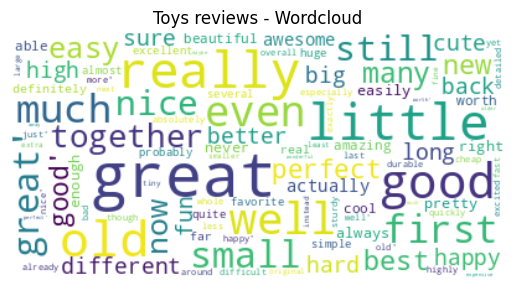

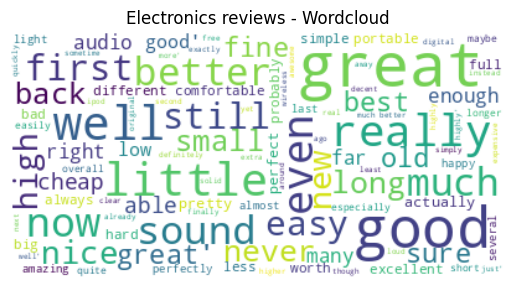

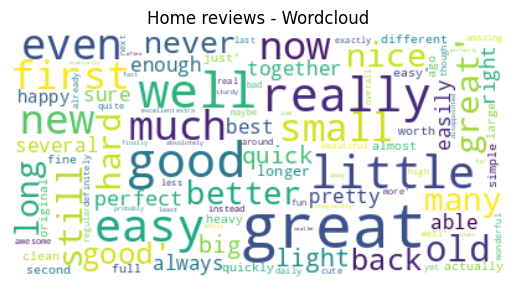

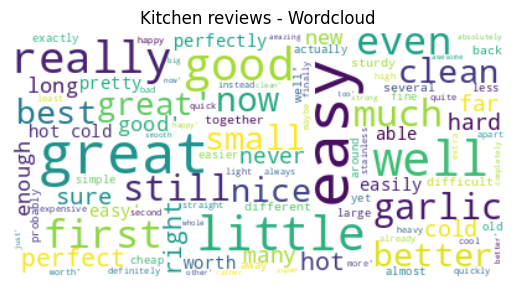

In [ ]:
# generating wordclouds
#texts = []
#texts_2 = []

texts = [' '.join(tokens) for tokens in tokens_shoes]
shoes_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts))
plt.figure()
plt.title("Shoes reviews - Wordcloud")
plt.imshow(shoes_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

texts_2 = [' '.join(tokens) for tokens in tokens_toys]
toys_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts_2))
plt.figure()
plt.title("Toys reviews - Wordcloud")
plt.imshow(toys_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

texts_3 = [' '.join(tokens) for tokens in tokens_electronics]
electronics_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts_3))
plt.figure()
plt.title("Electronics reviews - Wordcloud")
plt.imshow(electronics_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


texts_4 = [' '.join(tokens) for tokens in tokens_home]
home_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts_4))
plt.figure()
plt.title("Home reviews - Wordcloud")
plt.imshow(home_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

texts_5 = [' '.join(tokens) for tokens in tokens_kitchen]
kitchen_wordcloud = WordCloud(max_font_size=50, 
                               max_words=100, 
                               background_color="white").generate(str(texts_5))
plt.figure()
plt.title("Kitchen reviews - Wordcloud")
plt.imshow(kitchen_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Reset to subset of data
Running this cell allows us to reset `df` to contain only the sub-set of categories we want to work with.

In [7]:
df = df_1.copy()

NameError: ignored

## Baseline models
We work with two baseline models:
1. Random classifier - we expect this to perform badly as there are five categories.
2. A logistic regression - which takes the vectorised text as an input. 



We first define a function to give us key metrics of precision and recall for all of the models we will try. 
- Precision/ positive predictive value:

$$\frac{true\_positives}{true\_positives + false\_positives}$$

- Recall/ sensitivity:

$$\frac{true\_positives}{true\_positives + false\_negatives}$$

In [ ]:
# defining the metrics
def get_metrics(y_trues, y_preds, verbose=True):

  recall_macro = recall_score(y_trues, y_preds, average = "macro") * 100          
  precision_macro = precision_score(y_trues, y_preds, average = "macro") * 100 

  recall_weighted = recall_score(y_trues, y_preds, average = "weighted") * 100          
  precision_weighted = precision_score(y_trues, y_preds, average = "weighted") * 100

  if verbose:
    print(f'Precision: {precision_macro:.2f}')
    print(f'Recall: {recall_macro:.2f}')

    print(f'Precision (weighted average): {precision_weighted:.2f}')
    print(f'Recall (weighted average): {recall_weighted:.2f}')

  return recall_macro, precision_macro, recall_weighted, precision_weighted

### Baseline 1: Random Classifier

We calculate the metrics for making random guesses. As expected, this 'model' can only get it right about 1/5, so 20% of the time as there a five categories.

In [ ]:
precisions, recalls = [], []
precisions_w, recalls_w = [], []

for i in range(1000):
  trues = np.random.randint(0, 5, 1000)
  preds = np.random.randint(0, 5, 1000)

  precision, recall, precision_w, recall_w = get_metrics(trues, preds, verbose=False)
  
  precisions.append(precision)
  recalls.append(recall)

  precisions_w.append(precision_w)
  recalls_w.append(recall_w)

print('Final metrics')
print(f'Precision: {np.mean(precisions):.2f} ({np.std(precisions):.2f})')
print(f'Recall: {np.mean(recalls):.2f} ({np.std(recalls):.2f})')

print(f'Precision (weighted): {np.mean(precisions_w):.2f} ({np.std(precisions_w):.2f})')
print(f'Recall (weighted): {np.mean(recalls_w):.2f} ({np.std(recalls_w):.2f})')

Final metrics
Precision: 19.98 (1.25)
Recall: 19.98 (1.25)
Precision (weighted): 19.98 (1.25)
Recall (weighted): 20.06 (1.26)


### Baseline 2: Logistic Regression
We first convert the text to numerical features through the TfidfVectorizer. Then we fit and predict, usuing a multinomial logistic regression. 

We only use a simple test-train split rather than additionally generating a validation set as we do not go through a process of tuning hyperparameters.


In [ ]:
# Test-train split - NB need to no longer refer to train and dev if we are not using them here
#X_train, y_train = df_train['review_body'], df_train['product_category']
#X_test, y_test = df_development['review_body'], df_development['product_category']

df_train, df_valid = train_test_split(df, test_size=0.2, random_state=2000, stratify=df['product_category'])

X_train, y_train = df_train['review_body'], df_train['product_category']
X_test, y_test = df_valid['review_body'], df_valid['product_category']

In [ ]:
# Convert text data to numerical features
vectorizer = TfidfVectorizer()
X_train_v = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

# Train logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_v, y_train)

# Evaluate model on test set
y_pred = model.predict(X_test_v)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
get_metrics(y_test, y_pred)

Precision: 94.24
Recall: 74.59
Precision (weighted average): 93.84
Recall (weighted average): 93.81


(74.59218322059237, 94.23757739344849, 93.81050527762163, 93.83849182977357)

1. Metrics when average = macro
````
get_metrics(y_test, y_pred)
Precision: 94.42
Recall: 71.69
(71.68504311643586, 94.42449439776209)
````
2. Metrics when average = weighted
````
Precision: 93.84
Recall: 93.81
(93.81050527762163, 93.83849182977357)
````
It's possible to see that the logistic regression represents a huge increase in the metrics of the model like precision and recall.

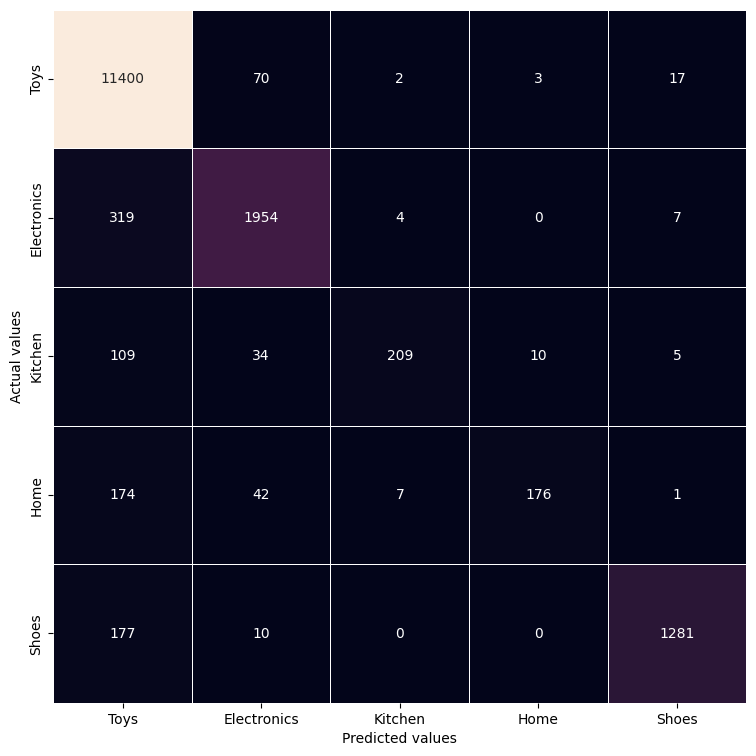

In [ ]:
# understanding the errors, plotting confusion matrix
from sklearn import metrics

# Get unique class labels
class_names = df['product_category'].unique()

# Generate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=class_names)

# Create heatmap with class labels on x and y axes
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()


In our first baseline model it's possible to see how the model performs well, specially for the classes with the biggest representativity in our sample (Toys, Eletronics and Shoes). For Home and Kitchen the model still makes a lot of wrong predictions, classifying it like toys, which makes sense becasue the probability of be a Toy review (71.7%) is much more bigger than the probability of be a Kitchen (2.2%) or a Home review (2.5%).



In [ ]:
# Identifying which word is most common in each prediction

X_test = pd.DataFrame(X_test)
X_test['prediction'] = y_pred



#### Additional pre-processing for the logistic regression model

We tried to improve the baseline model by looking at the errors, improving the pre-processing.




In [ ]:
# ensuring we get the same partition
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=2000, stratify=df['product_category'])

X_train, y_train = df_train['review_body'], df_train['product_category']
X_test, y_test = df_valid['review_body'], df_valid['product_category']

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Define preprocessing functions
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Convert to lowercase
    text = text.lower()
    return text

def tokenize_text(text):
    # Tokenize text into words
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_stopwords(tokens):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def stem_tokens(tokens):
    # Stem tokens
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(t) for t in tokens]
    return stemmed_tokens

# Preprocess training data
X_train_clean = [clean_text(text) for text in X_train]
X_train_tokens = [tokenize_text(text) for text in X_train_clean]
X_train_tokens = [remove_stopwords(tokens) for tokens in X_train_tokens]
X_train_tokens = [stem_tokens(tokens) for tokens in X_train_tokens]

# Preprocess test data
X_test_clean = [clean_text(text) for text in X_test]
X_test_tokens = [tokenize_text(text) for text in X_test_clean]
X_test_tokens = [remove_stopwords(tokens) for tokens in X_test_tokens]
X_test_tokens = [stem_tokens(tokens) for tokens in X_test_tokens]

# Convert preprocessed text data to numerical features
vectorizer = TfidfVectorizer()
X_train_v = vectorizer.fit_transform([' '.join(tokens) for tokens in X_train_tokens])
X_test_v = vectorizer.transform([' '.join(tokens) for tokens in X_test_tokens])


In [ ]:
# Train logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_v, y_train)

# Evaluate model on test set
y_pred = model.predict(X_test_v)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
get_metrics(y_test, y_pred)

Precision: 93.90
Recall: 76.06
Precision (weighted average): 93.94
Recall (weighted average): 93.93


(76.06481787053806, 93.90389140686544, 93.929173693086, 93.94108940727173)

1. Metrics when average = macro
````
get_metrics(y_test, y_pred)
Precision: 93.90
Recall: 76.06
(76.06481787053806, 93.90389140686544)
````
2. Metrics when average = weighted
````
Precision (weighted average): 93.94
Recall (weighted average): 93.93
(93.929173693086, 93.94108940727173)
````
After the pre-processing the performance of our baseline model didn't get better, in fact got even worse in both parameters of average. In our sense, the main reason behind of this could be teh loss of information when removing the stopwords/stemming.




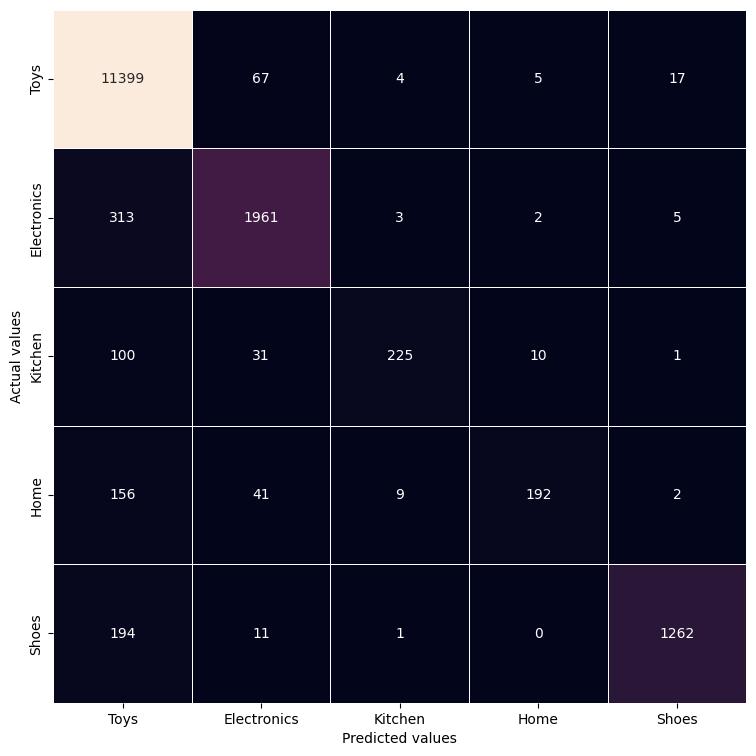

In [ ]:
# understanding the errors, plotting confusion matrix
from sklearn import metrics

# Get unique class labels
class_names = df['product_category'].unique()

# Generate confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred, labels=class_names)

# Create heatmap with class labels on x and y axes
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt='d', linewidth=0.5, square=True, cbar=False,
            xticklabels=class_names, yticklabels=class_names)

plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()


Trying to answer this we reviewed the perfomance of each pre-process separately.

In [ ]:
# now without cleaning 
# getting the data again
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=2000, stratify=df['product_category'])

X_train, y_train = df_train['review_body'], df_train['product_category']
X_test, y_test = df_valid['review_body'], df_valid['product_category']

# Preprocess training data
#X_train_clean = [clean_text(text) for text in X_train]
X_train_tokens = [tokenize_text(text) for text in X_train_clean]
X_train_tokens = [remove_stopwords(tokens) for tokens in X_train_tokens]
X_train_tokens = [stem_tokens(tokens) for tokens in X_train_tokens]

# Preprocess test data
#X_test_clean = [clean_text(text) for text in X_test]
X_test_tokens = [tokenize_text(text) for text in X_test_clean]
X_test_tokens = [remove_stopwords(tokens) for tokens in X_test_tokens]
X_test_tokens = [stem_tokens(tokens) for tokens in X_test_tokens]

# Convert preprocessed text data to numerical features
vectorizer = TfidfVectorizer()
X_train_v = vectorizer.fit_transform([' '.join(tokens) for tokens in X_train_tokens])
X_test_v = vectorizer.transform([' '.join(tokens) for tokens in X_test_tokens])


# Train logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X_train_v, y_train)

# Evaluate model on test set
y_pred = model.predict(X_test_v)

print("-----------------------------------")
get_metrics(y_test, y_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


-----------------------------------
Precision: 93.90
Recall: 76.06
Precision (weighted average): 93.94
Recall (weighted average): 93.93


(76.06481787053806, 93.90389140686544, 93.929173693086, 93.94108940727173)

## First model - RNN

In [ ]:
# reset dataset to only include chosen categories
df_2 = df.copy()


In [ ]:
#df_2.reset_index()
print(df_2.shape)
df_2.head()

(80051, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
28949,US,52210074,RXUM81XJ79S95,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,2.0,3.0,N,N,So many wonderful aspects to this simple toy!,While this is the sleek 90's version of the ch...,1999-07-01
32892,US,51142284,R5WOLGKAYGJRJ,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,0.0,0.0,N,N,"Great for reminiscing, but slightly outdated",I loved it when my children first received thi...,1999-08-11
33568,US,51227838,R16QQCPFC9ERVX,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,2.0,3.0,N,N,daughters favorte toy,my daughter can beat this phone up and it stil...,1999-08-19
33746,US,51623533,RMMQEO33W55Z7,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,4.0,5.0,N,N,An enduring favorite from my own childhood.,It is so wonderful to see a childhood favorite...,1999-08-20
34450,US,51740512,R2N4NN7RNYOGD2,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,19.0,24.0,N,N,...RiNg..rInG..911~May I help you?,Do you need to use your phone but can't pry it...,1999-08-28


In [ ]:
df_2["review_body"][231690]

'Wow! I just used my Rosle garlic press for the first time today. I cant believe how easily the unpeeled garlic went right through the holes. One good squeeze was all it took, the garlic almost squirted out. All that was left inside the press were the skins. This is a beautiful piece of engineering, made of heavy duty stainless steel. It seems to be a very durable kitchen tool. A breeze to wash, the garlic rinsed off easily under running water.<BR> <br />This item is a little expensive but I feel like it was worth the price. After fighting with inferior presses for many years, I finally found a great one. I like the Rosle garlic press so much I just ordered three more, one for each of my children.'

### Additional  library imports
to move to top later

In [ ]:
import numpy as np
from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#stop = set(stopwords.words('english'))

from sklearn import metrics

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.callbacks import ModelCheckpoint, EarlyStopping

import keras
from keras.models import Sequential
from keras import layers

from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop

#tfds.disable_progress_bar()
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Pre-processing
 - adding bespoke stopwords
 - removing punctuation and stopwords, and generating lower case text
 - generate a vocaulary list and a dictionary as well as its reverse

#### Removing punctuation and stopwords

In [ ]:
new_stopwords = ["br", 'would', 'one']

stpwrd = stopwords.words('english')
stpwrd.extend(new_stopwords)


We define two functions to pre-pocess the text:
1. remove_punct - removes punctuation, namely `!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~`
2. remove_stopwords - removes stopwords, such as 'and', 'or', 'at', 'don't' and also makes text lower case 

While some stopwords may be important for sentiment analysis, we are focussed on being able to predict the category.

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)


def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stpwrd]
    return " ".join(filtered_words)


In [ ]:
# just in case a review is just a number
df_2['review_body'] = df_2['review_body'].astype(str)


In [ ]:
df_2["review_body_punc"] = df_2.review_body.map(remove_punct)
df_2["review_body_final"] = df_2.review_body_punc.map(remove_stopwords)

df_2.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_body_punc,review_body_final
28949,US,52210074,RXUM81XJ79S95,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,2.0,3.0,N,N,So many wonderful aspects to this simple toy!,While this is the sleek 90's version of the ch...,1999-07-01,While this is the sleek 90s version of the cha...,sleek 90s version chatter phone smooth edges f...
32892,US,51142284,R5WOLGKAYGJRJ,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,0.0,0.0,N,N,"Great for reminiscing, but slightly outdated",I loved it when my children first received thi...,1999-08-11,I loved it when my children first received thi...,loved children first received phone similar pl...
33568,US,51227838,R16QQCPFC9ERVX,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,2.0,3.0,N,N,daughters favorte toy,my daughter can beat this phone up and it stil...,1999-08-19,my daughter can beat this phone up and it stil...,daughter beat phone still keeps working nothin...
33746,US,51623533,RMMQEO33W55Z7,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,4.0,5.0,N,N,An enduring favorite from my own childhood.,It is so wonderful to see a childhood favorite...,1999-08-20,It is so wonderful to see a childhood favorite...,wonderful see childhood favorite mine enjoyed ...
34450,US,51740512,R2N4NN7RNYOGD2,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,19.0,24.0,N,N,...RiNg..rInG..911~May I help you?,Do you need to use your phone but can't pry it...,1999-08-28,Do you need to use your phone but cant pry it ...,need use phone cant pry little ones handstry g...


#### Numerical target column

It is easier to work with a numerical target column.

In [ ]:
df_2.product_category.unique()

array(['Toys', 'Electronics', 'Kitchen', 'Home', 'Shoes'], dtype=object)

In [ ]:
#categories = ['Shoes', 'Home', 'Kitchen','Toys', 'Electronics'] 

df_2['target'] = df_2['product_category'].replace(['Shoes', 'Home', 'Kitchen', 'Toys', 'Electronics'],
                        [0, 1, 2, 3, 4], inplace=False) 

# for three categories
#df_2['target'] = df_2['product_category'].replace([ 'Shoes', 'Home', 'Kitchen'], #'Toys', 'Electronics',
#                        [0, 1, 2], inplace=False) #4, 5



In [ ]:
df_2.iloc[0:1,:]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_body_punc,review_body_final,target
28949,US,52210074,RXUM81XJ79S95,B00000IZOR,887358849,Fisher-Price Chatter Telephone [older version],Toys,4.0,2.0,3.0,N,N,So many wonderful aspects to this simple toy!,While this is the sleek 90's version of the ch...,1999-07-01,While this is the sleek 90s version of the cha...,sleek 90s version chatter phone smooth edges f...,3


#### Turn reviews into vectors

We count the unique words in the new review_body. There are 69,947 unique words and we show the most common ones.

In [ ]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df_2["review_body_final"])

In [ ]:
num_unique_words = len(counter)
print("Number of unique words: " + str(num_unique_words))
counter.most_common(15)

Number of unique words: 69947


[('great', 21597),
 ('game', 17642),
 ('like', 14879),
 ('good', 13050),
 ('love', 11995),
 ('get', 11224),
 ('little', 10642),
 ('play', 10525),
 ('really', 10484),
 ('well', 10450),
 ('set', 9560),
 ('time', 9502),
 ('old', 9326),
 ('bought', 8900),
 ('loves', 8899)]

We split the data into a training and a validation set and extrat the text and the target columns to separate arrays. We show the dimensions and an example of the stored values.

In [ ]:
# Split dataset into training and validation set
df_train, df_valid = train_test_split(df_2, test_size=0.2, random_state=2000, stratify=df_2['product_category'])
print(df_train.shape, df_valid.shape)

# split text and labels
train_sentences = df_train.review_body_final.to_numpy()
valid_sentences = df_valid.review_body_final.to_numpy()

train_labels = df_train.target.to_numpy()
valid_labels = df_valid.target.to_numpy()

print(valid_labels[1], valid_sentences[1])

(64040, 18) (16011, 18)
3 bought 6 year old son christmas liked lot think afraid play looks fragile used plastic collapsible ones hard find larger toy stores ive seen darth maul anakins lightsabers looking specifically paid much much similar ones sell 30 something wouldnt spent anything lightsabers light disappears hilt like real clashes hit something pretty cool im happier purchase son currently leaning corner room


We employ a tokenizer to generate a dictionary with indices.

In [ ]:
# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training


# each word has unique index
word_index = tokenizer.word_index
type(word_index)  # dict

word_index_examples = {k: word_index[k] for k in list(word_index)[200:205]}
print(word_index_examples)


# Reverse the indices
# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

reverse_index_examples = {k: reverse_word_index[k] for k in list(reverse_word_index)[200:205]}
print(reverse_index_examples)

{'fine': 201, 'shoe': 202, 'said': 203, 'order': 204, 'enjoy': 205}
{201: 'fine', 202: 'shoe', 203: 'said', 204: 'order', 205: 'enjoy'}


In [ ]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

No we can use the dictionary to transform each sentence into a sequence of indices (key) that refer to the values in the dictionray. We can use the decoder for the reverse process.

We wonder whether we should additionally stem the words, as we can see that "loves" and "loved" are encoded the same way. However, we may also be removing too much information.

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
valid_sequences = tokenizer.texts_to_sequences(valid_sentences)

print(train_sentences[0:3])
print(train_sequences[0:3])

print('_________________________________________________________________________________________________________________________________________')

decoded_text = decode(train_sequences[3])

print(train_sequences[3])
print(decoded_text)

['daughter loves interchange parts many sets loves definitely good buy'
 'granddaughter loved seen movie presents requested went perfectly castle santa brought'
 'good value works well']
[[34, 15, 9688, 225, 77, 166, 15, 154, 4, 30], [186, 37, 396, 319, 2146, 1995, 329, 336, 578, 1164, 954], [4, 357, 67, 10]]
_________________________________________________________________________________________________________________________________________
[38, 20, 188, 1184, 24, 1904, 4124, 1977, 524, 1040, 1411, 341, 16746, 1411, 406, 1686, 63, 6262, 163, 7121, 339]
nice quality cable fair price allowed bypass failed hdmi input hd tv regain hd picture vs new circuit board labor charge


The RNN model will take inputs of equal length. We therefore check how long the review texts are. It seems that the majority have less than 30 words, so we use that as the input size. For shorter reviews, we pad the remaning spaces with zeros.

In [ ]:
df_2['word_count'] = df_2['review_body_final'].str.count(' ') + 1
df_2['word_count'].describe()

count    80051.000000
mean        26.583803
std         46.278377
min          1.000000
25%          8.000000
50%         15.000000
75%         29.000000
max       3669.000000
Name: word_count, dtype: float64

In [ ]:
#df_2['word_count'].value_counts().plot(kind='bar')

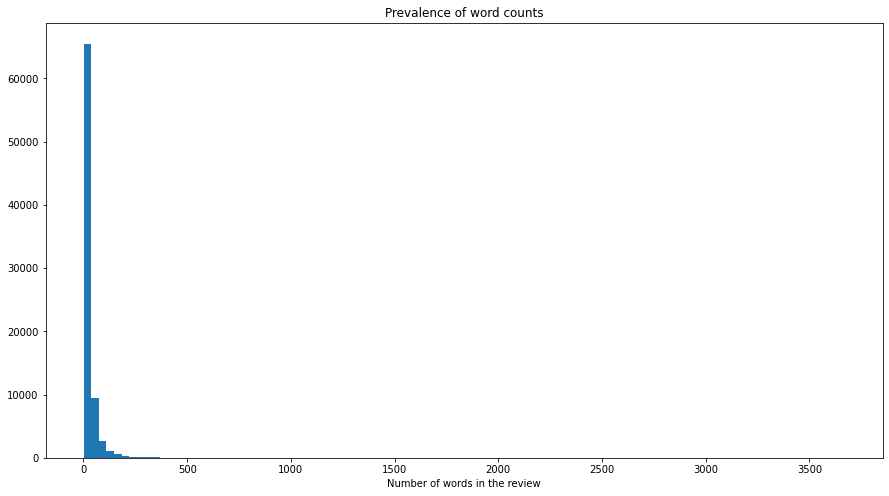

In [ ]:
#matplotlib.pyplot.hist
plt.figure(figsize=(15,8))
plt.hist(df_2['word_count'], bins=100)
plt.title('Prevalence of word counts')
plt.xlabel('Number of words in the review')
plt.show()

In [ ]:
# Max number of words in a sequence
max_length = 400

# Padding
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding="post", truncating="post")

train_padded.shape, valid_padded.shape

((64040, 400), (16011, 400))

In [ ]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

gift grandson upcoming birthday mother assured thrilled delivered less 48 hrs
[48, 131, 4251, 157, 1549, 7122, 627, 1001, 228, 4190, 3378]
[  48  131 4251  157 1549 7122  627 1001  228 4190 3378    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    

### RNN model training
Here we specify the archiecture of the neural network with an embedding layer at the start and a final output layer that returns a probability of each label being the true one for a given review.



In [ ]:
model = Sequential()

In [ ]:
# Embedding layer: https://keras.io/api/layers/core_layers/embedding/

model.add(layers.Embedding(input_dim = num_unique_words, output_dim = 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.2))
model.add(layers.Dense(32, activation="relu"))
#model.add(layers.Dense(10, activation="relu"))

model.add(layers.Dense(5, activation="softmax")) # 3 if using 3 categories  - alternative: sigmoid

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 32)           2238304   
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2,265,381
Trainable params: 2,265,381
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = keras.losses.SparseCategoricalCrossentropy() # alternative: categorical_crossentropy - but no binary keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metric = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metric)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
valid_labels

array([4, 3, 1, ..., 3, 3, 3])

In [ ]:
# fit the model

history = model.fit(
  train_padded,
  train_labels,
  epochs=10, #20 were not enough for convergrence
  batch_size=32,
  #callbacks=[EarlyStopping(monitor='val_loss', patience=3)], #, min_delta=0.0001)],
  validation_split=0.2
)



Epoch 1/10
1601/1601 [==============================] - 34s 18ms/step - loss: 0.9207 - accuracy: 0.7178 - val_loss: 0.9244 - val_accuracy: 0.7160
Epoch 2/10
1601/1601 [==============================] - 32s 20ms/step - loss: 0.9142 - accuracy: 0.7182 - val_loss: 0.9216 - val_accuracy: 0.7160
Epoch 3/10
1601/1601 [==============================] - 28s 17ms/step - loss: 0.9126 - accuracy: 0.7189 - val_loss: 0.9215 - val_accuracy: 0.7160
Epoch 4/10
1601/1601 [==============================] - 29s 18ms/step - loss: 0.9124 - accuracy: 0.7188 - val_loss: 0.9260 - val_accuracy: 0.7163
Epoch 5/10
1601/1601 [==============================] - 27s 17ms/step - loss: 0.9114 - accuracy: 0.7189 - val_loss: 0.9205 - val_accuracy: 0.7163
Epoch 6/10
1601/1601 [==============================] - 31s 19ms/step - loss: 0.9113 - accuracy: 0.7189 - val_loss: 0.9218 - val_accuracy: 0.7159
Epoch 7/10
1601/1601 [==============================] - 28s 17ms/step - loss: 0.9114 - accuracy: 0.7190 - val_loss: 0.9228 -

In [ ]:
model.save_weights('rnn_5_5cat.h5')   #1,2,3 on Friday 24 March, 4 on Saturday, 25 March
# model_new.load_weights('rnn_1_3cat.h5')

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


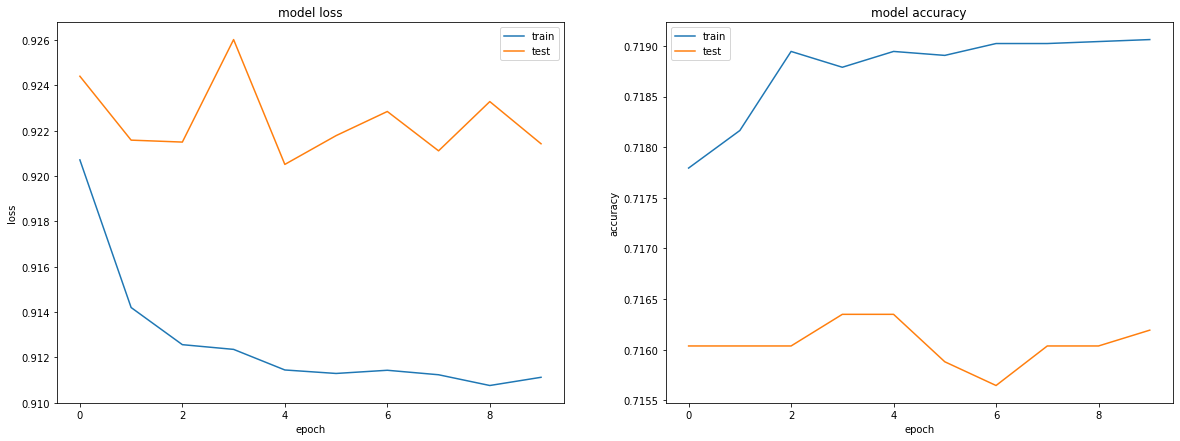

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(20, 7))
# loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

# accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

#show
plt.show()



### Evaluate the RNN model

We use the model above to make predictions for which category each of the reviews in the validation set is. As shown, the y_pred output indicates which of the (five) categories is the most likely for each review. As we only want a single predicted category for each review, we apply an argmax argument, which returns the index with the highest value.

Now we can compare the predictions to the true label values of the validation set. We show a confustion matrix as well as a more detailed breakdown of  precision, recall and  f1-score for each category.

Overall, the RNN models we speciy are is not able to outperform the Logistic Regression above.

In [ ]:
y_pred = model.predict(valid_padded)


501/501 [==============================] - 6s 10ms/step


In [ ]:
y_pred

array([[0.08657213, 0.02347606, 0.02325295, 0.73002166, 0.13667725],
       [0.08657213, 0.02347606, 0.02325295, 0.73002166, 0.13667725],
       [0.08657213, 0.02347606, 0.02325295, 0.73002166, 0.13667725],
       ...,
       [0.08657213, 0.02347605, 0.02325295, 0.73002166, 0.13667722],
       [0.08657213, 0.02347605, 0.02325295, 0.73002166, 0.13667722],
       [0.08657213, 0.02347605, 0.02325295, 0.73002166, 0.13667722]],
      dtype=float32)

In [ ]:
y_pred_f = np.argmax(y_pred,axis=1)

In [ ]:
y_pred_f

array([3, 3, 3, ..., 3, 3, 3])

Reminder of the numerical references to the target category:
- 0 : Shoes
- 1: Home
- 2: Kitchen
- 3: Toys
- 4: Electronics



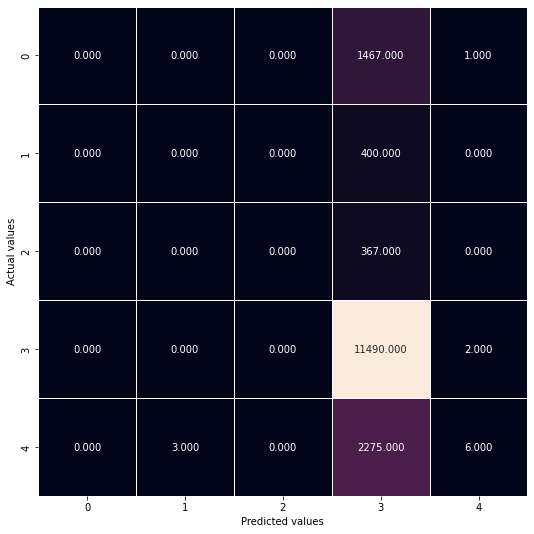

In [ ]:
#generates a 5x5 matrix
cm = metrics.confusion_matrix(valid_labels, y_pred_f)

# turns it into a more digestable heatmap format
plt.figure(figsize = (9,9))
sns.heatmap(cm, annot = True, fmt = '0.3f', linewidth = 0.5,
            square = True, cbar = False)

plt.ylabel('Actual values')
plt.xlabel('Predicted values')
plt.show()

Unsurprisingly, the model performs best for the categories that have the largest support, i.e. toys, shoes and electronics.

Meanwhile home and kitchen not only have fewer reviews to train on, but are also harder to classify as the reviews are likely to use more similar vocabulary.

In [ ]:
print(metrics.classification_report(valid_labels, y_pred_f))

# 0:Shoes, 1:Home, 2:Kitchen, 3:Toys, 4:Electronics

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1468
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       367
           3       0.72      1.00      0.84     11492
           4       0.67      0.00      0.01      2284

    accuracy                           0.72     16011
   macro avg       0.28      0.20      0.17     16011
weighted avg       0.61      0.72      0.60     16011



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### History of models and their performance:

1. Model with **12** epochs, batch size **32**:

````
model.add(layers.Embedding(input_dim = num_unique_words, output_dim = 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(5, activation="sigmoid")) 
````

Performance on **5** imbalanced categories: 

````              
                precision    recall  f1-score   support

           0       0.96      0.87      0.91      1468
           1       0.79      0.53      0.64       400
           2       0.76      0.67      0.71       367
           3       0.95      0.98      0.96     11492
           4       0.91      0.86      0.88      2284

    accuracy                           0.94     16011
   macro avg       0.87      0.78      0.82     16011
weighted avg       0.93      0.94      0.93     16011

0:Shoes, 1:Home, 2:Kitchen, 3:Toys, 4:Electronics
```


2. Model with **20** epochs, batch size **32**:

````
model.add(layers.Embedding(input_dim = num_unique_words, output_dim = 32, input_length=max_length))

model.add(layers.LSTM(20, dropout=0.1))
model.add(layers.Dense(10, activation="relu"))
model.add(layers.Dense(5, activation="softmax"))
````

Performance:

````
              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1468
           1       0.64      0.53      0.58       400
           2       0.74      0.62      0.67       367
           3       0.95      0.98      0.96     11492
           4       0.89      0.86      0.88      2284

    accuracy                           0.93     16011
   macro avg       0.83      0.77      0.80     16011
weighted avg       0.93      0.93      0.93     16011
````

3. Model with **200** epochs, batch size **32** and an extra layer:

````
model.add(layers.Embedding(input_dim = num_unique_words, output_dim = 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.2))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(10, activation="relu"))

model.add(layers.Dense(5, activation="softmax"))
````

Performance:

````
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1468
           1       0.67      0.50      0.57       400
           2       0.75      0.62      0.68       367
           3       0.95      0.97      0.96     11492
           4       0.89      0.87      0.88      2284

    accuracy                           0.93     16011
   macro avg       0.83      0.77      0.80     16011
weighted avg       0.92      0.93      0.92     16011
````

4. Model with **10** epochs, batch size **32** and an extra layer:

**KEY CHANGE: ** vector or 400 rather than 30

````
model.add(layers.Embedding(input_dim = num_unique_words, output_dim = 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.2))
model.add(layers.Dense(32, activation="relu"))

model.add(layers.Dense(5, activation="softmax"))
````

Performance:

````
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1468
           1       0.00      0.00      0.00       400
           2       0.00      0.00      0.00       367
           3       0.72      1.00      0.84     11492
           4       0.67      0.00      0.01      2284

    accuracy                           0.72     16011
   macro avg       0.28      0.20      0.17     16011
weighted avg       0.61      0.72      0.60     16011
````

### Improvements through gridsearching RNN parameters

We can also search over lots of other aspects of the model as outlined in detail here: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Due to time (and laptop) contratints, we weren't able to experiment with more of them, but here is what else we could have tried to gridsearch over:
-  **optimizers** - although adam seems to consistently perform well, alternative options are ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
- going a level deeper: the **learning rate and momentum** when using the Stochastic Gradient Descent (SDG) rather than Adam
````
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.2)
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(optimizer__learning_rate=learn_rate, optimizer__momentum=momentum)
`````

- **weight initialisation** for the network
````
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(model__init_mode=init_mode)
````
- the **activation function** of a dense layer (except for the last one)
````
def create_model(activation='relu'):
    model = Sequential()
    model.add(Dense(12, input_shape=(8,), kernel_initializer='uniform', activation=activation))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(model__activation=activation)
````
- regularisation through **dropout** (which apparently is best combined with a weight constraint such as the max norm constraint)
````
def create_model(dropout_rate, weight_constraint):
    model = Sequential()
    model.add(Dense(12, input_shape=(8,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint)
````

- even the **number of neurons** in a hidden layer:
````
...
    model.add(Dense(neurons, input_shape=(8,), kernel_initializer='uniform', activation='linear', kernel_constraint=MaxNorm(4)))
neurons = [1, 5, 10, 15, 20, 25, 30]
param_grid = dict(model__neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
````

Here we try to improve performance by varyting tha batch size for a simple model.

In [ ]:
!pip install scikeras

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

#!pip install scikit-optimize
#from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def create_model():
	# create model
  model = Sequential()
  model.add(layers.Embedding(input_dim = num_unique_words, output_dim = 32, input_length=max_length))
  model.add(layers.LSTM(64, dropout=0.1))
  model.add(layers.Dense(32, activation="relu"))
  model.add(layers.Dense(5, activation="sigmoid"))  
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = KerasClassifier(model=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 40]         #, 70, 100] # 20, 60, 80,
epochs = [15, 30]             # 70]  #[10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = HalvingGridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)


In [ ]:
# currently give: ValueError: `logits` and `labels` must have the same shape, received ((None, 5) vs (None, 1)).
# this may be an ssue of having multiple classes
# athough my understanding is that KerasClassifier should be able to deal with that


grid_result = grid.fit(train_padded, train_labels)


In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Understand the underyling algorithm
LIME 
https://marcotcr.github.io/lime/tutorials/Lime%20-%20multiclass.html

In [ ]:
import locale

def getpreferrencoding(do_setlocale = True):
  return lambda: "UTF-8" #"UTF-8"

locale.getpreferredencoding = locale.getpreferredencoding



In [ ]:
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install lime
from lime.lime_text import LimeTextExplainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=2186744c3e4c314103a618afbd61fee922c730187f83cda4b9b08b61d6415cfa
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


## BERT

In [ ]:
#https://www.tensorflow.org/text/tutorials/classify_text_with_bert
#https://www.youtube.com/watch?v=wp9BudYGZyA
#https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#!pip install -q -U "tensorflow-text==2.11.*"
#!pip install -q tf-models-official==2.11.0

import os
import shutil
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

from sklearn.model_selection import train_test_split

TypeError: ignored

In [ ]:
#!pip list | grep tensorflow
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 KB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorf

In [ ]:
# reset dataset
df_3 = df_1.copy()

In [ ]:
# I will be using the base BERT model: bert_en_uncased_L-12_H-768_A-12

bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
bert_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


In [ ]:
# not required?
#df_3['review_length'] = df['review_body'].apply(lambda x: len(str(x)))

Below we build our model:
- text_input sp 
- encoder_inputs: 

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_model, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='relu', name='intermediate_layer')(net)
  output_layer = tf.keras.layers.Dense(5, activation='softmax')(net)
  return tf.keras.Model(text_input, output_layer)

classifier_model = build_classifier_model()

NameError: ignored

In [ ]:
df_3['product_category_num'] = df_3['product_category'].map({'Toys': 0,
                                            'Electronics': 1,
                                            'Kitchen': 2,
                                            'Home': 3,
                                            'Shoes': 4})
labels = np.zeros((len(df_3), len(df_3['product_category_num'].unique())))

labels[np.arange(len(df_3)), df_3['product_category_num'].values] = 1

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df_3['review_body'], labels, test_size=0.25)

def get_batches(X_train, y_train, batch_size):

    X_train, y_train = shuffle(X_train, y_train, random_state=11)

    i, j = 0, 0

    while i > -1:

        if (len(X_train) - j*batch_size) < batch_size:
            j = 0
            X_train, y_train = shuffle(X_train, y_train, random_state=11)

        sentences = X_train[j*batch_size: (j+1) * batch_size]
        targets = y_train[j*batch_size: (j+1) * batch_size, :]
        j += 1

        yield sentences, targets


num_batches = 45

batches = get_batches(x_train, y_train, num_batches)

NameError: ignored

In [ ]:
cat_acc = tf.keras.metrics.CategoricalAccuracy(name="accuracy")
adam = tf.keras.optimizers.Adam(learning_rate = 1e-5)
cat_crossent = tf.keras.losses.CategoricalCrossentropy()

classifier_model.compile(optimizer = adam, loss = cat_crossent, metrics = [cat_acc, tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
n_epochs = 25
for batch in batches:
  model_fit = classifier_model.fit(batch[0], batch[1], epochs = n_epochs, validation_data = (x_test, y_test))

NameError: ignored

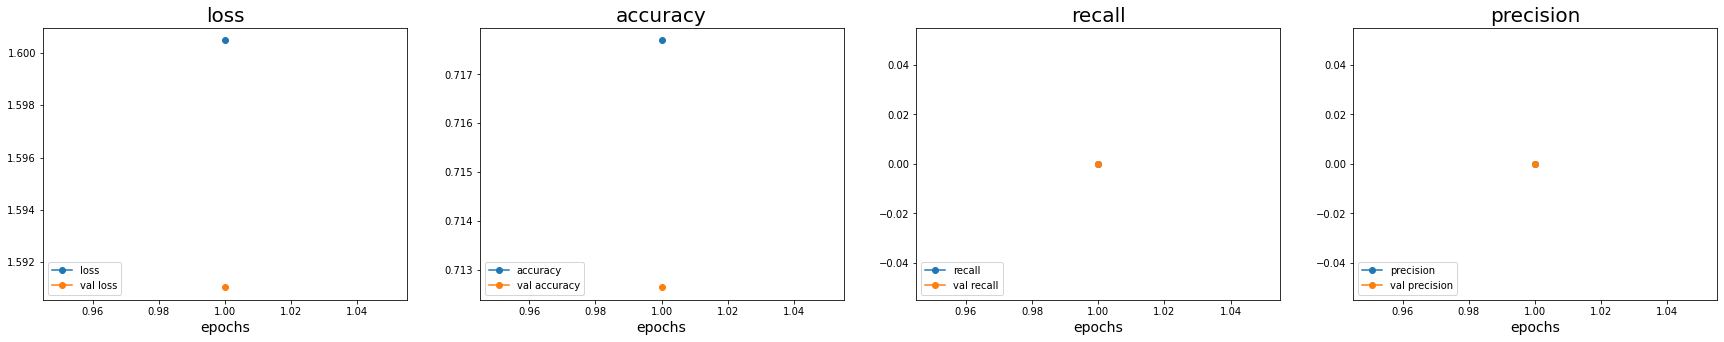

In [ ]:
x = list(range(1, n_epochs+1))
metric_list = list(model_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, model_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, model_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

### Test-validation-train split
We separate the data into in three sets: train, development and test. We check that the generated data sets are representative of the relative review frequencies.


In [ ]:
df_train, df_test = train_test_split(df_1, test_size=0.2, random_state=2000, stratify=df_1['product_category'])
# splititng the train in train and development set
df_train, df_development = train_test_split(df_train, test_size=0.2, random_state=2000, stratify=df_train['product_category'])


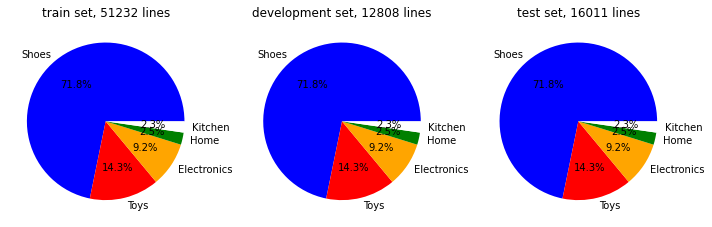

In [ ]:
# assuring all datasets are balanced between classes
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
for i, (df, name) in enumerate(zip([df_train, df_development, df_test], ['train', 'development', 'test'])):
  y = df['product_category'].value_counts().values / len(df) * 100
  ax[i].pie(y, colors=['blue', 'red', 'orange', 'green', 'white'], autopct='%1.1f%%', labels=['Shoes', 'Toys', 'Electronics', 'Home', 'Kitchen'])
  ax[i].set_title(f'{name} set, {len(df)} lines')
fig.show()